This code is meant to train a custom CNN on the Malaria cell data and measure its performance to aid in improved malaria disease screening. However, you can use these codes as the skeleton to make use of your own custom CNN for your task of interest. A sample data fold is included just to run the script and show how the results look like. 

To begin with, let us define a few functions to load the data and convert them to Keras compatible targets. Lets begin loading the libraries.

In [1]:
# load libraries
import cv2
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
import itertools
import time
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
%matplotlib inline

Using TensorFlow backend.


We performed 5-fold cross validation at the patient level. we had train and test splits for each fold to ensure that none of the patienet information in the training data leaks into the test data. We randomly split 10% of the training data for validation. For simplicity, we used a single fold here to show how to run the script.

In [2]:
#define data directories
train_data_dir = '/harddisk2/dtyu/f1_mal/train'
valid_data_dir = '/harddisk2/dtyu/f1_mal/valid'
test_data_dir = '/harddisk2/dtyu/f1_mal/valid'

# declare the number of samples in each category
nb_train_samples = 22045 #  modify for your dataset
nb_valid_samples = 5513 #  modify for your dataset
nb_test_samples = 5513 # modify for your dataset
num_classes = 2 # binary classification 
img_rows_orig = 100 # modify these values for your requirements 
img_cols_orig = 100

imageLabels = sorted(os.listdir(train_data_dir))
dictOfLabels = { imageLabels[i]: i for i in range(0, len(imageLabels) ) }

In [3]:
print(dictOfLabels)

{'0-Uninfected': 0, '1-Parasitized': 1}


Lets define functions to load and resize the training, validation and test data.

In [4]:
def load_training_data():
    labels =os.listdir(train_data_dir)   
    #for label in dictOfLabels:
    #    print(dictOfLabels[label])  
    X_train = np.ndarray((nb_train_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_train = np.zeros((nb_train_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for label in labels:
        image_names_train = os.listdir(os.path.join(train_data_dir, label))
        total = len(image_names_train)
        print(label, total)
        for image_name in image_names_train:
            img = cv2.imread(os.path.join(train_data_dir, label, image_name), cv2.IMREAD_COLOR)
            
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            #Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in RGB mode. So 
            #color images will not be displayed correctly in Matplotlib if image is read with OpenCV. 
            
            img = cv2.resize(img, (img_rows,img_cols))
            img = np.array([img])
            X_train[i] = img
            Y_train[i] = dictOfLabels[label]
            if i % 5000 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1                            
    print('Loading done.')
    print(X_train.shape)
    print('Transform targets to keras compatible format.')
    #Y_train = np_utils.to_categorical(Y_train[:nb_train_samples], num_classes)
    np.save('imgs_train.npy', X_train, Y_train) #save as numpy files
    return X_train, Y_train
    
def load_validation_data():
    # Load validation images
 
    labels = os.listdir(valid_data_dir)
    X_valid = np.ndarray((nb_valid_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_valid = np.zeros((nb_valid_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating validation images...')
    print('-'*30)
    for label in labels:
        image_names_valid = os.listdir(os.path.join(valid_data_dir, label))
        total = len(image_names_valid)
        print(label, total)
        for image_name in image_names_valid:
            img = cv2.imread(os.path.join(valid_data_dir, label, image_name), cv2.IMREAD_COLOR)
            
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            #Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in RGB mode. So 
            #color images will not be displayed correctly in Matplotlib if image is read with OpenCV. 
            
            img = cv2.resize(img, (img_rows,img_cols))
            img = np.array([img])
            X_valid[i] = img
            Y_valid[i] = dictOfLabels[label]
            if i % 1000 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    #Y_valid = np_utils.to_categorical(Y_valid[:nb_valid_samples], num_classes)
    np.save('imgs_valid.npy', X_valid, Y_valid) #save as numpy files
    return X_valid, Y_valid

def load_test_data():
    labels = os.listdir(test_data_dir)
    X_test = np.ndarray((nb_test_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_test = np.zeros((nb_test_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    for label in labels:
        image_names_test = os.listdir(os.path.join(test_data_dir, label))
        total = len(image_names_test)
        print(label, total)
        for image_name in image_names_test:
            img = cv2.imread(os.path.join(test_data_dir, label, image_name), cv2.IMREAD_COLOR)
            
            img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            #Color image loaded by OpenCV is in BGR mode. But Matplotlib displays in RGB mode. So 
            #color images will not be displayed correctly in Matplotlib if image is read with OpenCV. 
            
            img = cv2.resize(img, (img_rows,img_cols))
            img = np.array([img])
            X_test[i] = img
            Y_test[i] = dictOfLabels[label]
            if i % 1000 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    #Y_test = np_utils.to_categorical(Y_test[:nb_test_samples], num_classes)
    np.save('imgs_test.npy', X_test, Y_test) #save as numpy files
    return X_test, Y_test

We will define functions to resize the original images to that dimensions required for the custom CNN using the functions defined below.

In [5]:
def load_resized_training_data(img_rows, img_cols):

    X_train, Y_train = load_training_data()
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
    
    return X_train, Y_train
    
def load_resized_validation_data(img_rows, img_cols):

    X_valid, Y_valid = load_validation_data()
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    return X_valid, Y_valid   

def load_resized_test_data(img_rows, img_cols):

    X_test, Y_test = load_test_data()
    X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:nb_test_samples,:,:,:]])
    
    return X_test, Y_test

An evaluation script has been written to compute the confusion matrix for the performance of the trained model. This function prints and plots the confusion matrix. Normalization can be applied by setting 'normalize=True'.

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We will now proceed to train a sequential custom model on our dataset and visualize the confusion matrix, ROC and AUC curves.

In [7]:
img_rows=100 #dimensions of image for the custom CNN
img_cols=100
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 500 # modify depending on the model convergence with your data

#load data
X_train, Y_train = load_resized_training_data(img_rows, img_cols)
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)
X_test, Y_test = load_resized_test_data(img_rows, img_cols)


#print the shape of the data
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

------------------------------
Creating training images...
------------------------------
1-Parasitized 10988
Done: 0/10988 images
Done: 5000/10988 images
Done: 10000/10988 images
0-Uninfected 11057
Done: 15000/11057 images
Done: 20000/11057 images
Loading done.
(22045, 100, 100, 3)
Transform targets to keras compatible format.
------------------------------
Creating validation images...
------------------------------
1-Parasitized 2791
Done: 0/2791 images
Done: 1000/2791 images
Done: 2000/2791 images
0-Uninfected 2722
Done: 3000/2722 images
Done: 4000/2722 images
Done: 5000/2722 images
5513
Loading done.
Transform targets to keras compatible format.
------------------------------
Creating test images...
------------------------------
1-Parasitized 2791
Done: 0/2791 images
Done: 1000/2791 images
Done: 2000/2791 images
0-Uninfected 2722
Done: 3000/2722 images
Done: 4000/2722 images
Done: 5000/2722 images
5513
Loading done.
Transform targets to keras compatible format.
(22045, 100, 100, 

Let us now configure our custom model. The proposed CNN has three convolutional layers and two fully connected layers.
The input to the model constitutes segmented cells of 100 x100 x3 pixel resolution. The convolutional layers use 3 x 3 filters. The first and second convolutional layers have 32 filters and the third convolutional layer has 64 filters. The sandwich design of convolutional/rectified linear units (ReLU) and proper weight initialization enhances the learning process. Max-pooling layers with a pooling window of 2 x 2 and 2 pixel strides follow the convolutional layers for summarizing the outputs of neighboring neuronal groups in the feature maps. The pooled output of the third convolutional layer is fed to the first fully-connected layer that has 64 neurons, and the second fully connected layer feeds into the Softmax classifier.The optimal values for the hyperparamters were found separately by a randomized grid search method using the RandomizedSearchCV function. The model is trained by optimizing the multinomial logistic regression objective using stochastic gradient descent and Nesterov's momentum. We evaluated the performance of the customized model in terms of accuracy, Area Under Curve (AUC), sensitivity,specificity, F1-score and Matthews correlation coefficient (MCC).

In [8]:

#model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_rows, img_cols, channel)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(num_classes, activation='softmax'))
#model.add(Dense(num_classes, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#fix the optimizer
sgd = SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

#compile the model
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])




W0913 18:46:30.740131 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 18:46:30.760780 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 18:46:30.763982 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 18:46:30.775979 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0913 18:46:30.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
__________

Its time to train the model. We will store only the best model weights by initializing callbacks. Also we can view the performance of our model during run-time by visualizing the performance graphs with Tensorboard. Create a log directory named 'logs' to store the training logs and a separate folder named 'weights' to store the model weights. You can visualize tensorboard graphs simply by navigating to your working directory and do:

$tensorboard --logdir=path/to/log-directory/ --port 6006

Then open localhost:6006 in your browser to view the performance graphs, model architecture and other parameters of your interest.

In [9]:
filepath = 'weights/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='max', period=1)
tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board]

#compute training time
t=time.time()
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 callbacks=callbacks_list,
                 epochs=num_epoch, verbose=1, 
                 shuffle=True, validation_data=[X_valid, Y_valid])

#compute the training time
print('Training time: %s' % (time.time()-t))
savedModelName = 'weights/' + model.name + '-'+str(num_epoch)+'-FINAL-logistic.hdf5'
model.save(savedModelName)

W0913 18:46:37.026003 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 22045 samples, validate on 5513 samples


W0913 18:46:38.805577 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0913 18:46:38.806604 140384320349952 deprecation_wrapper.py:119] From /home/dtyu/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/500
22045/22045 [==============================] - 9s 423us/step - loss: 1.3698 - acc: 0.5788 - val_loss: 1.0743 - val_acc: 0.6135

Epoch 00001: val_acc improved from -inf to 0.61346, saving model to weights/sequential_1.01-0.6135.hdf5
Epoch 2/500
22045/22045 [==============================] - 8s 351us/step - loss: 1.0181 - acc: 0.6127 - val_loss: 0.9498 - val_acc: 0.6370

Epoch 00002: val_acc improved from 0.61346 to 0.63704, saving model to weights/sequential_1.02-0.6370.hdf5
Epoch 3/500
22045/22045 [==============================] - 8s 355us/step - loss: 0.9210 - acc: 0.6284 - val_loss: 0.8827 - val_acc: 0.6447

Epoch 00003: val_acc improved from 0.63704 to 0.64466, saving model to weights/sequential_1.03-0.6447.hdf5
Epoch 4/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.8578 - acc: 0.6452 - val_loss: 0.8761 - val_acc: 0.6459

Epoch 00004: val_acc improved from 0.64466 to 0.64593, saving model to weights/sequential_1.04-0.6459.hdf5
Epoch 5/500
220

22045/22045 [==============================] - 8s 353us/step - loss: 0.3842 - acc: 0.8364 - val_loss: 0.4437 - val_acc: 0.8092

Epoch 00074: val_acc did not improve from 0.81498
Epoch 75/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.3825 - acc: 0.8347 - val_loss: 0.4365 - val_acc: 0.8172

Epoch 00075: val_acc improved from 0.81498 to 0.81716, saving model to weights/sequential_1.75-0.8172.hdf5
Epoch 76/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.3795 - acc: 0.8394 - val_loss: 0.4312 - val_acc: 0.8195

Epoch 00076: val_acc improved from 0.81716 to 0.81952, saving model to weights/sequential_1.76-0.8195.hdf5
Epoch 77/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.3768 - acc: 0.8392 - val_loss: 0.4344 - val_acc: 0.8164

Epoch 00077: val_acc did not improve from 0.81952
Epoch 78/500
22045/22045 [==============================] - 8s 355us/step - loss: 0.3760 - acc: 0.8410 - val_loss: 0.4423 - val_acc: 0.

22045/22045 [==============================] - 8s 354us/step - loss: 0.2410 - acc: 0.9069 - val_loss: 0.3078 - val_acc: 0.8796

Epoch 00151: val_acc did not improve from 0.88173
Epoch 152/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.2392 - acc: 0.9089 - val_loss: 0.3163 - val_acc: 0.8817

Epoch 00152: val_acc did not improve from 0.88173
Epoch 153/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.2371 - acc: 0.9092 - val_loss: 0.3056 - val_acc: 0.8846

Epoch 00153: val_acc improved from 0.88173 to 0.88464, saving model to weights/sequential_1.153-0.8846.hdf5
Epoch 154/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.2378 - acc: 0.9083 - val_loss: 0.3189 - val_acc: 0.8741

Epoch 00154: val_acc did not improve from 0.88464
Epoch 155/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.2369 - acc: 0.9084 - val_loss: 0.3056 - val_acc: 0.8841

Epoch 00155: val_acc did not improve from 0.88

22045/22045 [==============================] - 8s 353us/step - loss: 0.2057 - acc: 0.9224 - val_loss: 0.2846 - val_acc: 0.8946

Epoch 00190: val_acc did not improve from 0.90042
Epoch 191/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.2050 - acc: 0.9232 - val_loss: 0.2851 - val_acc: 0.8944

Epoch 00191: val_acc did not improve from 0.90042
Epoch 192/500
22045/22045 [==============================] - 8s 356us/step - loss: 0.2033 - acc: 0.9255 - val_loss: 0.2859 - val_acc: 0.8946

Epoch 00192: val_acc did not improve from 0.90042
Epoch 193/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.2024 - acc: 0.9247 - val_loss: 0.2718 - val_acc: 0.9024

Epoch 00193: val_acc improved from 0.90042 to 0.90241, saving model to weights/sequential_1.193-0.9024.hdf5
Epoch 194/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.2028 - acc: 0.9250 - val_loss: 0.2722 - val_acc: 0.9011

Epoch 00194: val_acc did not improve from 0.90


Epoch 00229: val_acc did not improve from 0.91003
Epoch 230/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1810 - acc: 0.9322 - val_loss: 0.2564 - val_acc: 0.9077

Epoch 00230: val_acc did not improve from 0.91003
Epoch 231/500
22045/22045 [==============================] - 8s 355us/step - loss: 0.1812 - acc: 0.9330 - val_loss: 0.2787 - val_acc: 0.8975

Epoch 00231: val_acc did not improve from 0.91003
Epoch 232/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.1797 - acc: 0.9326 - val_loss: 0.2536 - val_acc: 0.9077

Epoch 00232: val_acc did not improve from 0.91003
Epoch 233/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1792 - acc: 0.9353 - val_loss: 0.2543 - val_acc: 0.9104

Epoch 00233: val_acc improved from 0.91003 to 0.91039, saving model to weights/sequential_1.233-0.9104.hdf5
Epoch 234/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1786 - acc: 0.9344 - val_loss: 0.2568 


Epoch 00270: val_acc did not improve from 0.91475
Epoch 271/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1638 - acc: 0.9419 - val_loss: 0.2402 - val_acc: 0.9149

Epoch 00271: val_acc improved from 0.91475 to 0.91493, saving model to weights/sequential_1.271-0.9149.hdf5
Epoch 272/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1641 - acc: 0.9395 - val_loss: 0.2420 - val_acc: 0.9157

Epoch 00272: val_acc improved from 0.91493 to 0.91565, saving model to weights/sequential_1.272-0.9157.hdf5
Epoch 273/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.1645 - acc: 0.9416 - val_loss: 0.2410 - val_acc: 0.9140

Epoch 00273: val_acc did not improve from 0.91565
Epoch 274/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1635 - acc: 0.9407 - val_loss: 0.2402 - val_acc: 0.9122

Epoch 00274: val_acc did not improve from 0.91565
Epoch 275/500
22045/22045 [==============================] - 8s 3

22045/22045 [==============================] - 8s 356us/step - loss: 0.1422 - acc: 0.9490 - val_loss: 0.2286 - val_acc: 0.9206

Epoch 00353: val_acc did not improve from 0.92255
Epoch 354/500
22045/22045 [==============================] - 8s 355us/step - loss: 0.1403 - acc: 0.9510 - val_loss: 0.2267 - val_acc: 0.9193

Epoch 00354: val_acc did not improve from 0.92255
Epoch 355/500
22045/22045 [==============================] - 8s 356us/step - loss: 0.1409 - acc: 0.9504 - val_loss: 0.2406 - val_acc: 0.9151

Epoch 00355: val_acc did not improve from 0.92255
Epoch 356/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1400 - acc: 0.9511 - val_loss: 0.2290 - val_acc: 0.9225

Epoch 00356: val_acc did not improve from 0.92255
Epoch 357/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1400 - acc: 0.9510 - val_loss: 0.2390 - val_acc: 0.9146

Epoch 00357: val_acc did not improve from 0.92255
Epoch 358/500
22045/22045 [===========================

22045/22045 [==============================] - 8s 355us/step - loss: 0.1320 - acc: 0.9538 - val_loss: 0.2223 - val_acc: 0.9240

Epoch 00395: val_acc did not improve from 0.92418
Epoch 396/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1324 - acc: 0.9548 - val_loss: 0.2221 - val_acc: 0.9236

Epoch 00396: val_acc did not improve from 0.92418
Epoch 397/500
22045/22045 [==============================] - 8s 355us/step - loss: 0.1326 - acc: 0.9531 - val_loss: 0.2208 - val_acc: 0.9238

Epoch 00397: val_acc did not improve from 0.92418
Epoch 398/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.1312 - acc: 0.9551 - val_loss: 0.2312 - val_acc: 0.9195

Epoch 00398: val_acc did not improve from 0.92418
Epoch 399/500
22045/22045 [==============================] - 8s 353us/step - loss: 0.1318 - acc: 0.9543 - val_loss: 0.2275 - val_acc: 0.9236

Epoch 00399: val_acc did not improve from 0.92418
Epoch 400/500
22045/22045 [===========================

22045/22045 [==============================] - 8s 354us/step - loss: 0.1189 - acc: 0.9596 - val_loss: 0.2257 - val_acc: 0.9227

Epoch 00479: val_acc did not improve from 0.92726
Epoch 480/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1183 - acc: 0.9597 - val_loss: 0.2154 - val_acc: 0.9262

Epoch 00480: val_acc did not improve from 0.92726
Epoch 481/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1183 - acc: 0.9594 - val_loss: 0.2260 - val_acc: 0.9225

Epoch 00481: val_acc did not improve from 0.92726
Epoch 482/500
22045/22045 [==============================] - 8s 354us/step - loss: 0.1186 - acc: 0.9589 - val_loss: 0.2143 - val_acc: 0.9264

Epoch 00482: val_acc did not improve from 0.92726
Epoch 483/500
22045/22045 [==============================] - 8s 352us/step - loss: 0.1177 - acc: 0.9599 - val_loss: 0.2176 - val_acc: 0.9258

Epoch 00483: val_acc did not improve from 0.92726
Epoch 484/500
22045/22045 [===========================

If you want to visualize the performance of the model in the console other than with Tensorboard, you can use the following script.

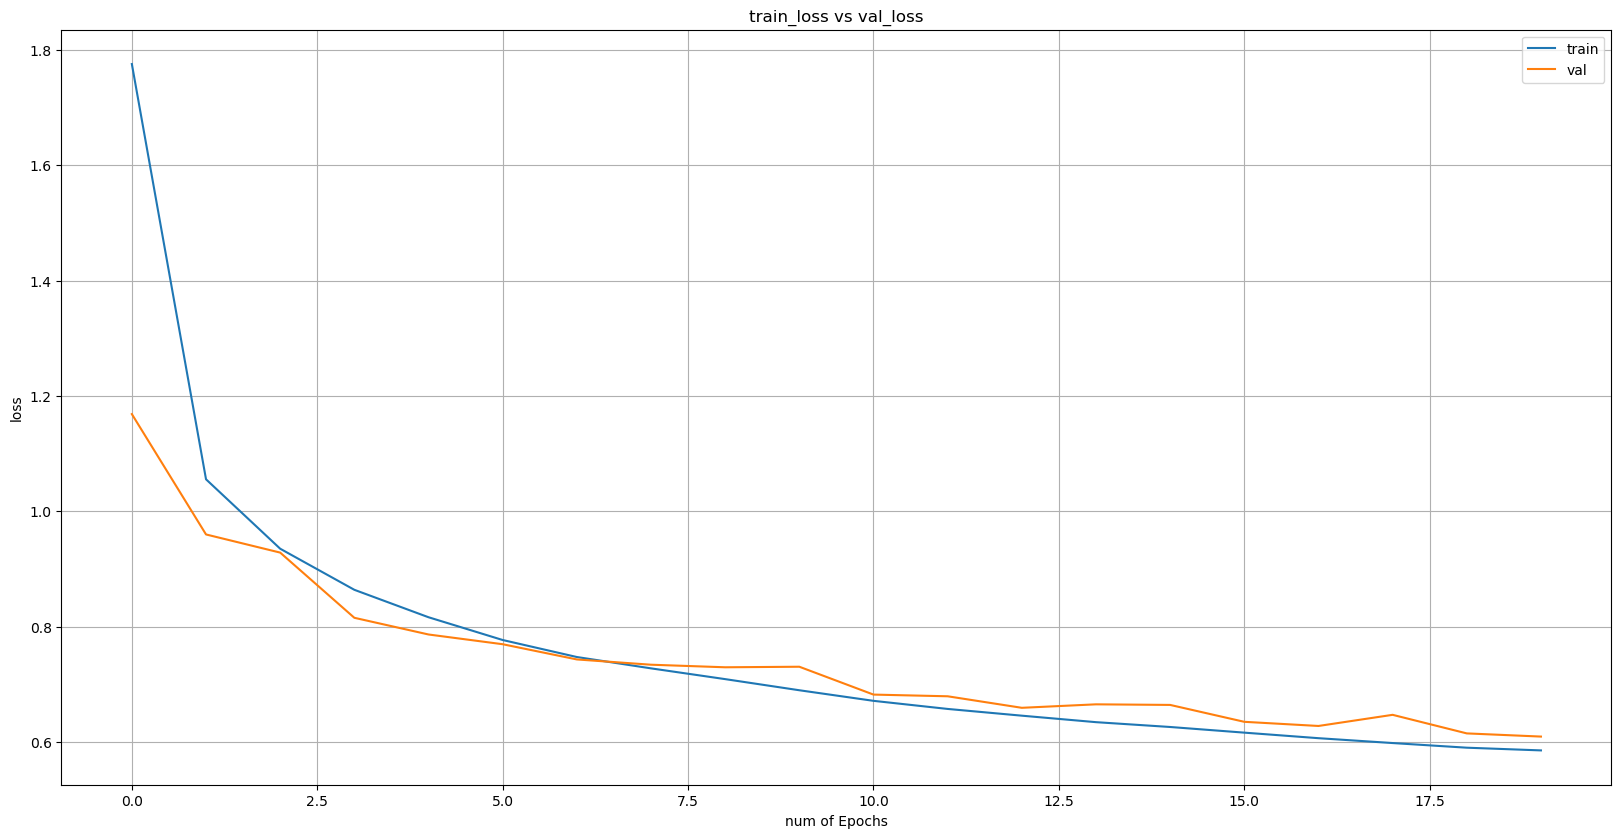

In [9]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=100)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=100)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

Once the model is trained, load the best model weights to predict on the test data. I just trained the model for a short time of 10 epochs and took the best out of it. 

In [10]:
model.load_weights('weights/' + model.name + '-'+str(num_epoch)+'-FINAL.hdf5') #modify for your own model

In [18]:
#predict on the test data
X_test, Y_test = load_resized_test_data(img_rows, img_cols)
print(X_test.shape, Y_test.shape)
print('-'*30)
print('Predicting on the test data...')
print('-'*30)
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
#Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))

print(y_pred)
Test_accuracy = accuracy_score(Y_test, y_pred > 0.5)
print("Test_Accuracy = ",Test_accuracy)

------------------------------
Creating test images...
------------------------------
1-Parasitized 2791
Done: 0/2791 images
Done: 1000/2791 images
Done: 2000/2791 images
0-Uninfected 2722
Done: 3000/2722 images
Done: 4000/2722 images
Done: 5000/2722 images
5513
Loading done.
Transform targets to keras compatible format.
(5513, 100, 100, 3) (5513,)
------------------------------
Predicting on the test data...
------------------------------
5513/5513 [==============================] - 1s 133us/step
[[0.7486899 ]
 [0.22583795]
 [0.9005938 ]
 ...
 [0.4404772 ]
 [0.25730452]
 [0.93362486]]
Test_Accuracy =  0.7275530564121168


Let us now compute the performance metrics for the custom model with the test data. The performance metrics involve computing the ROC-AUC values, cross-entropy loss score, average precision score, prediction probabilities and storing these values and plotting the ROC curves.

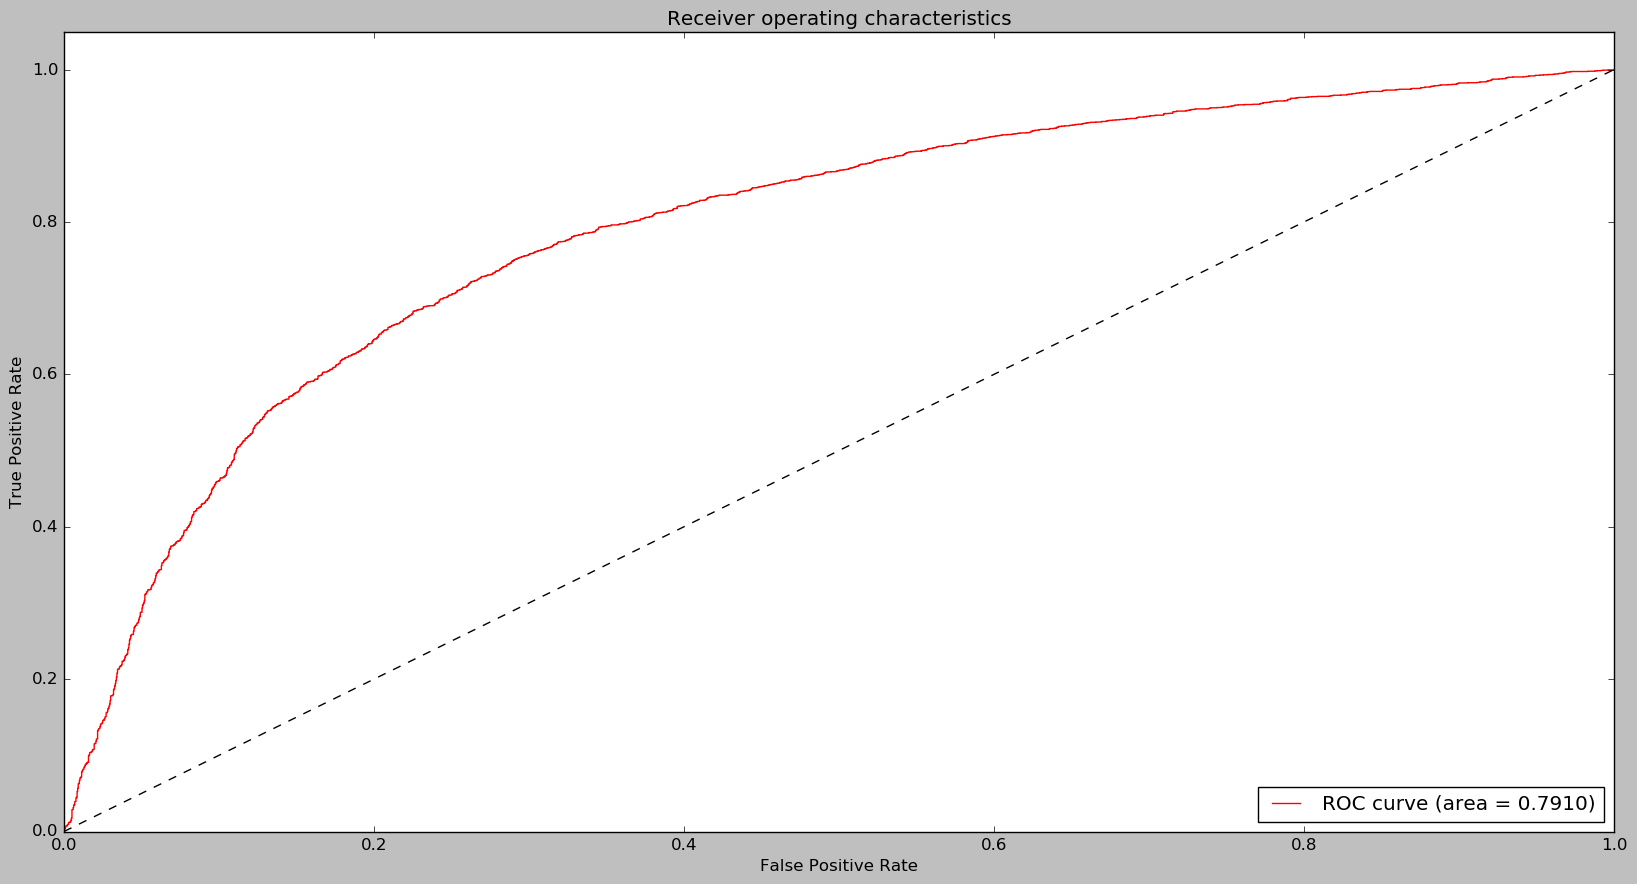

0.6093413018521919
0.7760269616058962
[[0.7486899 ]
 [0.22583795]
 [0.9005938 ]
 ...
 [0.4404772 ]
 [0.25730452]
 [0.93362486]]
[1 1 1 ... 0 0 0]


In [19]:
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
#for i in range(num_classes):
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
    
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(20,10), dpi=100)
lw = 1
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print(prec_score)

# transfer it back
#y_pred = np.argmax(y_pred, axis=1)
#Y_test = np.argmax(Y_test, axis=1)
print(y_pred)
print(Y_test)

#save the predictions as a CSV file for further analysis
np.savetxt('custom_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('custom_model_Y_test.csv',Y_test,fmt='%i',delimiter = ",")

Now, let us plot the confusion matrix to analyze the custom model's performance.

In [22]:
target_names = ['class 0(abnormal)', 'class 1(normal)'] #decide the labels for your own data
print(classification_report(Y_test,y_pred>0.5,target_names=target_names))
print(confusion_matrix(Y_test,y_pred>0.5))
cnf_matrix = (confusion_matrix(Y_test,y_pred>0.5))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()

                   precision    recall  f1-score   support

class 0(abnormal)       0.72      0.75      0.73      2722
  class 1(normal)       0.74      0.71      0.73      2791

        micro avg       0.73      0.73      0.73      5513
        macro avg       0.73      0.73      0.73      5513
     weighted avg       0.73      0.73      0.73      5513

[[2028  694]
 [ 808 1983]]
Confusion matrix, without normalization
[[2028  694]
 [ 808 1983]]


In [6]:
#savedModelName = 'weights/' + model.name + '-'+str(num_epoch)+'-FINAL.hdf5'
model.save(savedModelName)
print(savedModelName)
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file(savedModelName)
tflite_model = converter.convert()
tflitefilename = 'weights/'+savedModelName+"converted_model.tflite"
open(tflitefilename, "wb").write(tflite_model)

weights/sequential_1-500-FINAL.hdf5


W0913 20:10:58.822615 140152808466176 deprecation.py:323] From /home/dtyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0913 20:10:59.203604 140152808466176 deprecation.py:323] From /home/dtyu/anaconda3/lib/python3.7/site-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0913 20:10:59.204808 140152808466176 deprecation.py:323] From /home/dtyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and 

1756084

In [25]:
print(model.name)

sequential_1
